### Evrişimli sinir ağları(CNN) ile katı atık tespiti
1. Veriyi Anlamak
1. Veriyi Hazırlamak (Data Preparation)
1. Modelleme (Modelling)
1. Değerlendirme (Evaluation)

### Veriyi Anlamak
* Bu proje kapsamında kullanacağımız veri seti TrashNet isimli bir veri setidir. Standfort Üniversitesi öğrencileri tarafından Hazırlanmıştır.

* Veri seti altı farklı sınıftan oluşmaktadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır.

<br>

* 501 Cam
* 594 Kağıt
* 403 karton
* 482 plastik
* 410 metal
* 137 çöp

<br>

* Görüntüler Beyaz bir panoya yerleştirilerek ve güneş ışığı veya oda aydınlatması kullanılarak çekilmiştir. Görüntüler 512 x 384  piksel boyutlarında ve 3(RGB) kanallıdır.

## Gerekli Kütüphanelerin İmport Edilmesi

In [ ]:
import cv2
import urllib
import zipfile
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
#drive bağlantısı
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#verilerin drive daki dosya konumuna erişip, zip'i ayıklama
dir_path = "/content/drive/MyDrive/classification/data.zip"

#with zipfile.ZipFile(dir_path, "r") as zip_file:
#  zip_file.extractall("/content/drive/MyDrive/classification/unzipped3")

In [ ]:
#zip den çıkartılmış dosya adresi
new_dir_path = "/content/drive/MyDrive/classification/unzipped3/data/Garbage classification/Garbage classification"

In [ ]:
new_dir_path

'/content/drive/MyDrive/classification/unzipped3/data/Garbage classification/Garbage classification'

In [ ]:
#etiketleri ve giriş boyutunu belirleme
target_size = (224,224)

waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [ ]:
input_shape = (np.array(x[0]).shape[0], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [ ]:
def load_datasets(path):

  # x ve labels görüntü verilerini ve etiketleri saklamak için kullanılacak.
  x = []
  labels = []

  # path dizinindeki klasörler ve alt klasörlerdeki tüm görüntü dosyalarının içine erişir ve sıralı liste şeklinde image_path depişkenine atar.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img = cv2.imread(image_path)

    img = cv2.resize(img, target_size)

    x.append(img)


    # görüntünün klasör adını çıkartır. bu klasör adı görüntünün hangi klasöre ait olduğunu tespit eder. örn:metal,plastik
    # os.path.sep ifadesi işletim sistemine bağlı olarak dosya yolunun ayrıcısını temsil eder (/ veya \)
    # C:\Users\ERDEM\Desktop\data\\Garbage_classification\plastic\plastic16
    # \ göre ayırdı veriyi ve sonran 2'inci olan plastic klasör adına adın erişti.
    label = image_path.split(os.path.sep)[-2]

    labels.append(waste_labels[label])

  # etiket ve görüntü verilerini aynı şekilde karşılaştırıyoruz.
  # eğitim sürecinde daha dengeli ve çeşitli bir öğrenmeyi hedefliyoruz.
  x, labels = shuffle(x, labels, random_state = 42)

  print(f"X boyutu: {np.array(x).shape}")
  print(f"label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels

x, labels = load_datasets(new_dir_path)

X boyutu: (2527, 224, 224, 3)
label sınıf sayısı: 6 Gözlem sayısı: 2527


### Veri Setinden Örnekler Gösterilmesi

In [ ]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis("off")

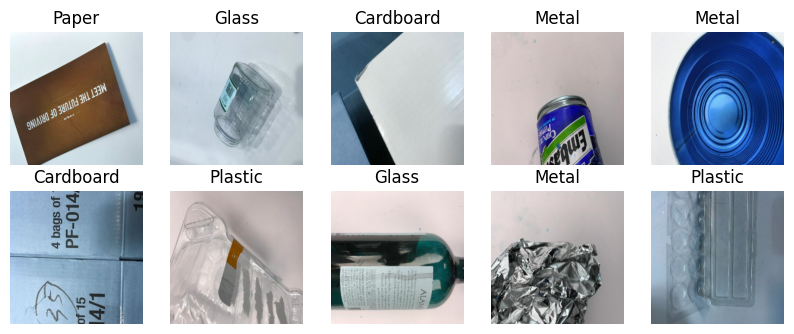

In [ ]:
visualize_img(x, labels)

### Veriyi Hazırlamak | Data Preparation | Data Augmentation

* Data Augmentation yöntemi bir veri arttırma yöntemdir, Veri çeşitlendirme aşırı öğrenmenin önüne geçer.

* Bu veriler beyaz bir panoda aydınlatma yapılarak hazırlanmıştır, ama gerçek hayttaki veriler bu kadar net veya stüdyo ortamında çekilmiş veriler olmayacaktır.

* Gerçek hayat verileri ile uyumlu olması için resimi dikeyde, yatayda çevirme işlemeleri, ölçeklendirme, yankınlaştırma vb. işlemler yapılır.

In [ ]:
#Train veri seti için generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)


#Test veri seti için generator tanımlıyoruz.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [ ]:
# flow_from_directory belirtilen adresteki görüntüleri yükler.
# target_size görüntülerin yeniden boyutlandırılacağı boyutları belirtir.
# class_mode etiketlerin kategorik olarak temsil edilmesi gerektiğini belirtir. çok sınıflı sınıflanfırma problemlerinde kullanılır.
# subset parametresi eğitim ve test verilerinin ayırılması için kullanılır.
# batch_size modelin doğrulama süreci için kullanacağı görüntü sayısını ifade eder. her iterasyonda 251 görüntü ile test işlem, gerçekleşecek

train_generator = train.flow_from_directory(directory = new_dir_path,
                                            target_size = (target_size),
                                            class_mode = "categorical",
                                            subset = "training")

test_generator = test.flow_from_directory(directory = new_dir_path,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = "categorical",
                                          subset = "validation")

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


### Modelleme (Modelling)
### CNN Modeli
* Sequential
* Evrişim Katmanı(Convolution Layer, Conv2D)
* Havuzlama Katmanı(Pooling Layer)
* Aktivasyon Fonksiyonu Katmanı(Activation Layer)
* Flattening Katmanı
* Dense Katmanı
* Dropout Katmanı

In [ ]:
# sequential katmanları sırayla eklemek için kullanılan bir model tipidir.
# Conv2D: 2D konvolüsyonal katmanıdır, görüntüdeki özellikleri öğrenir.
# filters=32, 32 adet filtre kullanılır. her filtre görüntünün farklı özelliklerini öğrenir.
# kernel_size, filtre boyutu 3x3'tür.
# padding="same" giriş ve çıkış boyutlarının aynı olmasını sağlar.
# input_shape modelin beklediği görüntünün boyutlarıdır. (224,244,3)
# activation="relu" ReLU aktivasyon fonksiyonu, negatif değerleri 0'a eşitlet pozitif değerleri olduğu gibi bırakır.
# ReLU modelin doğrusal olmayan özellikler öğrenmesine yardımcı olur.

# Havuzlama katmanı, Max_Pooling2D, bu katman gürültüyü ve modelin hesaplama yükünü azaltmak için kullanılır. görüntü boyutu küçültülür.
# pool_size=2; 2x2 havuzlama boyutu
# strides=(2,2) havuzlama işlemi sırasında her adımda 2 birim kaydırır.

# ikinci konvolüsyon katmanı 64 filtrelidir ve havuzlama katmanıda vardır.
# Bu katman modelin daha karmaşık özellikleri öğrenmesine yardımcı olur.

# Flatten, çok boyutlu çıkışı tek boyutlu hale getirir. Bu yoğun(fully connected) katmanlara geçiş yapmak için gereklidir.

# Dense yoğun bir katmandır, bu katman tüm giriş özelliklerinin her biri ile tam bağlantılıdır. units=64, 64 nöron içerir.
# dropout katmanı aşırı öğrenmeyi (overfitting) önlemek için rastgele nöronları kapatır, burada %20 oranında nöron kapatılır.
# en sondaki Dense katmanında unit=6 olması, 6 sınıflı bir çıktı katmanı olmasını temsil ediyor. bu yüzden softmax aktivasyon fonksiyonunu kullandık.

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation="softmax"))

In [ ]:
# burada oluşturmuş olduğumuz modelin yapısını özetliyoruz. bu özet modelin katmanları, her katman çıktısı
# parametre sayısı ve toplam model yapısı hakkında bilgi verir.

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

### Optimizasyon ve değerlendirme metriklerinin ayarlanması

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath="mymodel.keras", monitor="val_lose", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]

### Modelin Eğitilmesi

In [ ]:
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    steps_per_epoch=2276//32,
                    validation_steps=251//32)

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 719ms/step - acc: 0.2065 - loss: 1.8431 - precision: 0.2478 - recall: 0.0102 - val_acc: 0.3187 - val_loss: 1.5691 - val_precision: 0.7419 - val_recall: 0.0916
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.2812 - loss: 1.5786 - precision: 0.2500 - recall: 0.0312 - val_acc: 0.2988 - val_loss: 1.5657 - val_precision: 0.7059 - val_recall: 0.0956
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 551ms/step - acc: 0.3577 - loss: 1.5545 - precision: 0.5677 - recall: 0.0729 - val_acc: 0.3785 - val_loss: 1.4794 - val_precision: 0.9000 - val_recall: 0.1076
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.4375 - loss: 1.5865 - precision: 0.6667 - recall: 0.0625 - val_acc: 0.3904 - val_loss: 1.4828 - val_precision: 0.8889 - val_recall: 0.0956
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 532ms/step - acc: 0.4149 - loss: 1.4303 - precision: 0.6390 - recall: 0.1573 - val_acc: 0.4382 - val_loss: 1.3512 - val_precision: 0.7500 - val_recall: 0

### Accuracy ve Loss Grafikleri

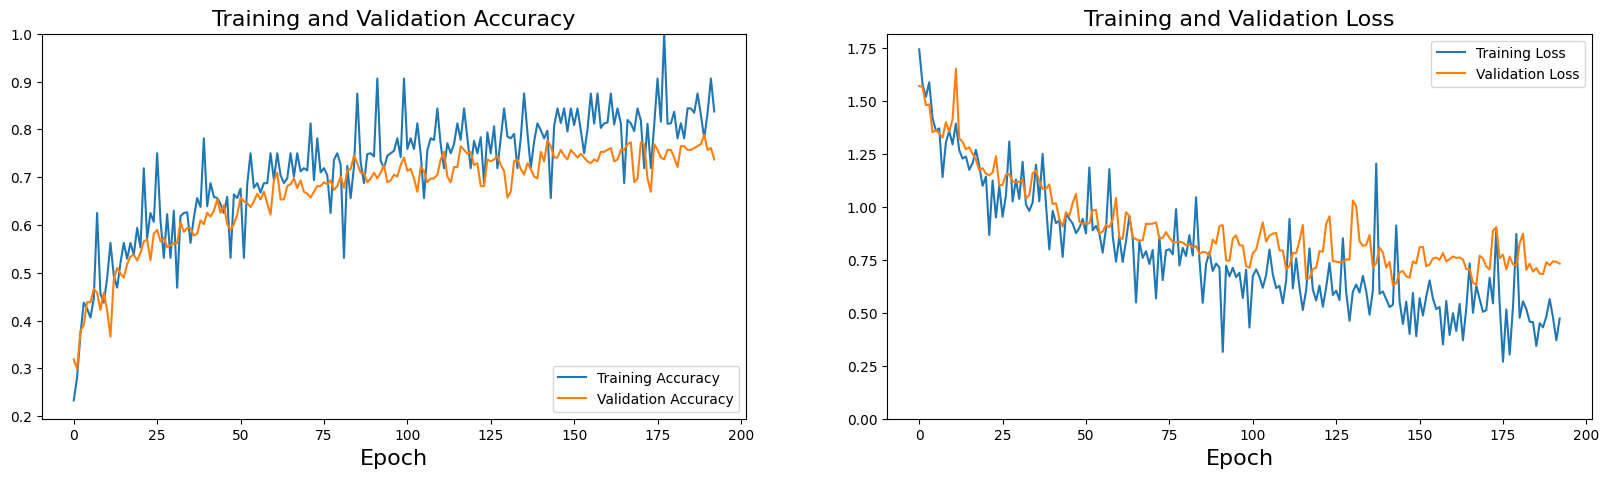

In [ ]:
#Accuracy Grafiği
#-------------------
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy", fontsize=16)


#Loss Grafiği
#-------------------
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")  # Burada "Upper right" yerine "upper right" kullanılmalı
plt.xlabel("Epoch", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

### Değerlendirme (Evaluation)

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.7371 - loss: 0.7315 - precision: 0.7945 - recall: 0.6932


In [ ]:
print("\nTest Accuracy: %1.f%%" % (100.0 * acc))
print("\nTest Loss: %1.f%%" % (100.0 * loss))
print("\nTest Precision: %1.f%%" % (100.0 * precision))
print("\nTest Recall: %1.f%%" % (100.0 * recall))


Test Accuracy: 74%

Test Loss: 73%

Test Precision: 79%

Test Recall: 69%


In [ ]:
#Classification Report
x_test, y_test = next(test_generator)

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


In [ ]:
target_names = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   cardboard       0.79      0.78      0.78        40
       glass       0.84      0.72      0.77        50
       metal       0.61      0.73      0.67        41
       paper       0.78      0.95      0.85        59
     plastic       0.79      0.46      0.58        48
       trash       0.50      0.77      0.61        13

    accuracy                           0.74       251
   macro avg       0.72      0.73      0.71       251
weighted avg       0.75      0.74      0.73       251



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


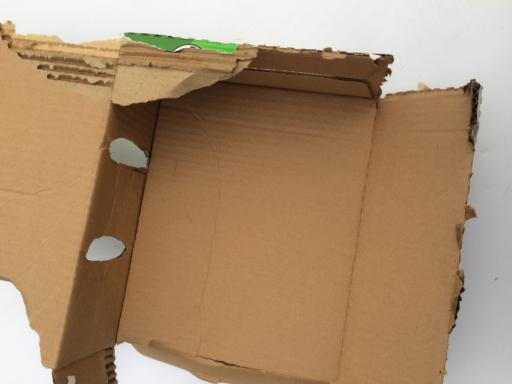

Tahmin Edilen Sınıf: 0
CNN algoritması tahmini: cardboard


In [ ]:
path = "/content/drive/MyDrive/classification/ornek3.jpg"
img = image.load_img(path, target_size=(224,224,3))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)


predicted_class = np.argmax(predictions, axis=1)



img_ = cv2.imread(path)
cv2_imshow(img_)

key = None
for k, v in waste_labels.items():
    if v == predicted_class[0]:
        key = k
        break

if key:
    print(f'Tahmin Edilen Sınıf: {predicted_class[0]}')
    print(f'CNN algoritması tahmini: {key}')
else:
    print('bulunamadı.')